# Auto Insurance claim prediction

## Data preprocessing

The large size of the original datasets will fail to upload to GitHub later.  Therefore, data preprocessing has been performed in a separated notebook, and the cleaned DataFrame is saved as 'df.csv' ready for use.

### 3 original datasets:
- Traffic Crashes - Crashes
- Traffic Crashes - Vehicles
- Traffic Crashes - People

### Preview and inspecting all 3 datasets:
- Inspecting the datasets.
- Based on project assumptions, adjust the DataFrames:
    - From df_crash, select ‘INJURIES_TOTAL’ = ‘0’
    - From df_people, select ‘PERSON_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘UNIT_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘VEHICLE_USE’ = ‘PERSONAL’

- Explore each column and decide what to keep.
- Merge all 3 DataFrames on column 'CRASH_RECORD_ID' and drop all null.
- Convert column 'AGE' and 'VEHICLE_YEAR' Dtype from float64 to int for for smaller data size.
- Save the cleaned DataFrame as 'df.csv'>


## Import libraries and load the cleaned DataFarame

In [1]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [129]:
df = pd.read_csv('df.csv')
df.head()

,Unnamed: 0,CRASH_DATE,DAMAGE,ZIPCODE,SEX,AGE,MAKE,MODEL,VEHICLE_YEAR
0,0,09/05/2018 08:40:00 AM,"OVER $1,500",60634,F,39,"TOYOTA MOTOR COMPANY, LTD.",4RUNNER,2002
1,1,09/05/2018 08:40:00 AM,"OVER $1,500",60634,F,39,"TOYOTA MOTOR COMPANY, LTD.",CAMRY,2014
2,2,09/05/2018 08:40:00 AM,"OVER $1,500",60625,M,32,"TOYOTA MOTOR COMPANY, LTD.",4RUNNER,2002
3,3,09/05/2018 08:40:00 AM,"OVER $1,500",60625,M,32,"TOYOTA MOTOR COMPANY, LTD.",CAMRY,2014
4,4,08/29/2022 11:30:00 AM,"$501 - $1,500",60620,F,40,NISSAN,ALTIMA,2017


In [130]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918968 entries, 0 to 918967
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CRASH_DATE    918968 non-null  object
 1   DAMAGE        918968 non-null  object
 2   ZIPCODE       918968 non-null  object
 3   SEX           918968 non-null  object
 4   AGE           918968 non-null  int64 
 5   MAKE          918968 non-null  object
 6   MODEL         918968 non-null  object
 7   VEHICLE_YEAR  918968 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 56.1+ MB


In [131]:
df['DAMAGE'].value_counts(normalize=True)

OVER $1,500      0.630675
$501 - $1,500    0.282473
$500 OR LESS     0.086852
Name: DAMAGE, dtype: float64

### Reset target df['DAMAGE'] from 3 outcomes to 2 outcomes

In [132]:
# In df['DAMAGE'], replace '$501 - $1,500' and 'OVER $1,500' with 'Over $500'
df_main = df.copy()
df_main['DAMAGE'] = df_main['DAMAGE'].replace(['$501 - $1,500', 'OVER $1,500'], 'Over $500')

In [133]:
df_main['DAMAGE'].value_counts(normalize=True)

Over $500       0.913148
$500 OR LESS    0.086852
Name: DAMAGE, dtype: float64

### Checking DataFrame memory usage and reset date range for smaller size

In [134]:
df_main =df_main[df_main['CRASH_DATE'] >= '12/20/2021']

In [135]:
# Take out 'ZIPCODE' and re-run the models

df_main = df_main.drop(['CRASH_DATE', 'ZIPCODE'], axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26934 entries, 39 to 913601
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DAMAGE        26934 non-null  object
 1   SEX           26934 non-null  object
 2   AGE           26934 non-null  int64 
 3   MAKE          26934 non-null  object
 4   MODEL         26934 non-null  object
 5   VEHICLE_YEAR  26934 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In [136]:
df_main.isna().sum()

DAMAGE          0
SEX             0
AGE             0
MAKE            0
MODEL           0
VEHICLE_YEAR    0
dtype: int64

In [137]:
df_main.memory_usage(deep=True)

Index            215472
DAMAGE          2273110
SEX             1669908
AGE              215472
MAKE            1769634
MODEL           1765765
VEHICLE_YEAR     215472
dtype: int64

### Define X and y, perform train_test_split

In [138]:
# define X and y:

X = df_main.drop('DAMAGE', axis=1)
y = df_main['DAMAGE']

# train_test_split:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [139]:
y_train

692925       Over $500
882323       Over $500
621295    $500 OR LESS
595498       Over $500
639360       Over $500
              ...     
736391    $500 OR LESS
202529       Over $500
48550        Over $500
549022       Over $500
815484    $500 OR LESS
Name: DAMAGE, Length: 20200, dtype: object

### Using Pipeline and FunctionTransformer

In [140]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int64'])

In [141]:
# The FunctionTransformer will turn my function into a transformer:

GrabNumeric = FunctionTransformer(grab_numeric)

In [142]:
# Pipe:

pipe = Pipeline([
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [143]:
# checking the resualt:

pipe.fit_transform(X_train)

array([[ 0.41466338, -0.09469565],
       [-0.65139391,  0.26361141],
       [ 1.54342991, -0.00511888],
       ...,
       [ 1.79426692,  0.08445788],
       [ 0.41466338, -0.27384918],
       [-1.27848643,  0.08445788]])

### Using Pipeline and ColumnTransformer


#### We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical

- numbers (AGE, VEHICLE_YEAR)
 - scale, impute

- categorical (all other columuns)
 - OHE, impute

In [144]:
# Numeric pipeline:

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

In [145]:
# Categorical pipeline:

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Selector and ColumnTransformer
This will return a callable list of columns

In [146]:
# The "remainder='passthrough" tells the compiler to leave the other df columns unchanged.
# The `ColumnTransformer` will take care of our preprocessing, so now we can add our model at the end of the pipeline:

CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include='int64')),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

In [147]:
# testing Selector:

test = selector(dtype_include='int64')
test(X_train)

['AGE', 'VEHICLE_YEAR']

### Bringing in Our Modeling Class from before

In [176]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = self.cv_mean
        print(cv_summary)
        
#         cv_summary = (
#         f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#         ''')
#         print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Models

### Model 1: Create Baseline Model - Dummy Classifier Model

In [177]:
dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [178]:
# Use the class without dummy pipe:

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy', X = X_train, y = y_train)

In [180]:
dummy_score_train = dummy_model_pipe.print_cv_summary()
dummy_score_train

0.9051485148514852


In [181]:
# Validate with testing data:
dummy_model.fit(X_train, y_train)
dummy_score_test = dummy_model.score(X_test, y_test)
dummy_score_test

0.907038907038907

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

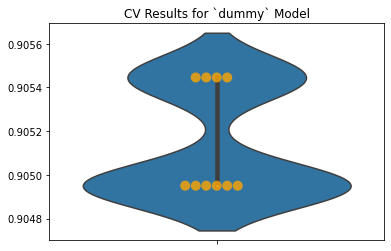

In [90]:
fig,ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

### Model 2: Create FSM (First Simple Model) - Logistic Regression Model

In [91]:
# Reset solver from 'lbfgs' to 'saga', and max_iter = 300

logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42, solver='saga', max_iter=300))
])

In [92]:
# Use the class with out logreg pipe

fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)

# Getting ConvergenceWarning. Go back to logreg_fsm above to reset the parameters.

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages

In [93]:
logreg_score_train = fsm_model_pipe.print_cv_summary()
logreg_score_train

CV Results for `fsm` model:
            0.90515 ± 0.00024 accuracy
        


In [94]:
# Validate with testing data:
logreg_fsm.fit(X_train, y_train)
logreg_score_test = logreg_fsm.score(X_test, y_test)
logreg_score_test

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.907038907038907

<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

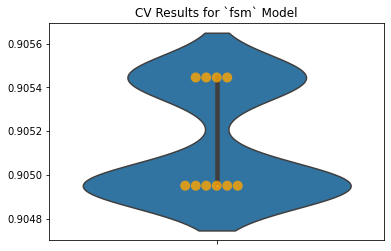

In [95]:
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

### Trying Other Models at the End of the Pipeline
### Model 3: Random Forest

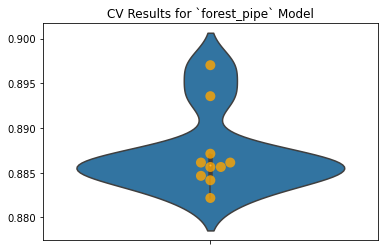

In [96]:
# rfc!
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [97]:
rfc_score_train = forest_pipe.print_cv_summary()
rfc_score_train

CV Results for `forest_pipe` model:
            0.88723 ± 0.00430 accuracy
        


In [98]:
# Validate with testing data:
rfc_model_pipe.fit(X_train, y_train)
rfc_score_test = rfc_model_pipe.score(X_test, y_test)
rfc_score_test

0.8814968814968815

### Model 4: Gradient Booster

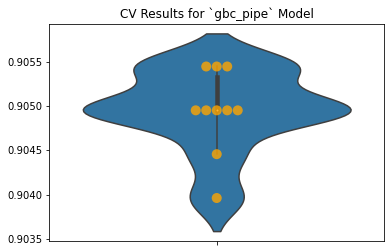

In [99]:
# gbc!
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_pipe = ModelWithCV(model=gbc_model_pipe,
                          model_name='gbc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax);

In [100]:
gbc_score_train = gbc_pipe.print_cv_summary()
gbc_score_train

CV Results for `gbc_pipe` model:
            0.90495 ± 0.00044 accuracy
        


In [101]:
# Validate with testing data:
gbc_model_pipe.fit(X_train, y_train)
gbc_score_test = gbc_model_pipe.score(X_test, y_test)
gbc_score_test

0.9064449064449065

## Take out column 'ZIPCODE' and re-run the models
It took 1h 32mins to excute Gradient Booster model.
Decided to take out Column 'ZIPCODE' since this dataset is collected in Chicago. Different 'ZIPCODE' might not impact the target much.

Before taking out ‘ZIPCODE’:
- CV Results for `dummy` model:  0.63879 ± 0.00009 accuracy
- CV Results for `forest_pipe` model:  0.62870 ± 0.00595 accuracy
- CV Results for `gbc_pipe` model:  0.63943 ± 0.00072 accuracy


### Model 5: Decision Tree

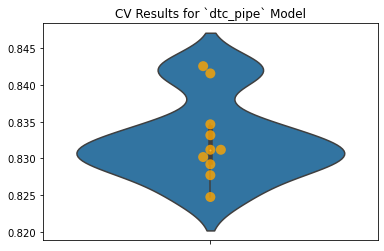

In [102]:
dtc_model_pipe = Pipeline([('ct', CT), ('dtc', DecisionTreeClassifier(random_state=42))])

dtc_pipe = ModelWithCV(model=dtc_model_pipe,
                          model_name='dtc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

dtc_pipe.plot_cv(ax=ax);

In [103]:
dtc_score_train = dtc_pipe.print_cv_summary()
dtc_score_train

CV Results for `dtc_pipe` model:
            0.83262 ± 0.00540 accuracy
        


In [104]:
# Validate with testing data:
dtc_model_pipe.fit(X_train, y_train)
dtc_score_test = dtc_model_pipe.score(X_test, y_test)
dtc_score_test

0.8313038313038313

### Model 6: Tuning and Cross-Validating - Logistic Regression Model

As a result, Logistic Regression Model has the best accuracy. Tune the Logreg Model and perform GridSearch:

In [168]:
# Checking logreg Pipeline:

logreg_fsm

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B3C2BEA370>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [169]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'logreg_fsm__max_iter':[500, 600],
    'logreg_fsm__class_weight':[None, 'balanced']
}

# Set up GridSearchCV and fit training data:
gs_logreg = GridSearchCV(estimator=logreg_fsm, param_grid=params, cv=10, verbose=2)

gs_logreg.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.0s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.4s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  36.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  37.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  37.9s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.9s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  41.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  44.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.5s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  53.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  49.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  52.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  50.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  50.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  52.9s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  50.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  48.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  52.6s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  53.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.9s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  37.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  36.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  37.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  36.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.5s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.5s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  43.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.4s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  43.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  43.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  43.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  50.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  48.8s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  48.7s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.0s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  51.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.8s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  39.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  35.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  38.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  34.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  36.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  37.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  42.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  43.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=600, total=  44.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  50.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  53.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  53.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  53.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  49.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  49.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  50.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  49.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  50.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=700, total=  51.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  36.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  36.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  36.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  37.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  35.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  38.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=500, total=  37.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  46.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  46.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.7s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.4s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  43.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  42.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  45.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  45.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  55.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  50.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  50.5s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  50.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  52.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  50.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.3s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  51.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700 


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 86.7min finished


[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=700, total=  49.3s


C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B3C2BEA370>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [170]:
gs_logreg.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'logreg_fsm__class_weight': None,
 'logreg_fsm__max_iter': 500}

In [171]:
tunedLogreg_score_train = gs_logreg.best_score_
tunedLogreg_score_train

0.9051485148514852

In [ ]:
# Validate with testing data:
tunedLogreg_score_test = gs_logreg.best_estimator_.score(X_test, y_test)
tunedLogreg_score_test

### Model 7: Tuning and Cross-Validating - Random Forest Model

In [152]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'rfc__criterion':['gini','entropy'],
    'rfc__max_depth':[1,3,5]
}

# Set up GridSearchCV and fit training data:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10, verbose=2)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gi

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.3s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.3s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   1.3s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__st

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   1.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   1.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.4min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B3C2BEA370>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [153]:
gs_rfc.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'rfc__criterion': 'gini',
 'rfc__max_depth': 1}

In [154]:
tunedRfc_score_train = gs_rfc.best_score_
tunedRfc_score_train

0.9051485148514852

In [155]:
# Validate with testing data:
tunedRfc_score_test = gs_rfc.best_estimator_.score(X_test, y_test)
tunedRfc_score_test

0.907038907038907

## Imblearn Pipelines
Dealing with the Target Imbalance, let's use SMOTE.

In [156]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [157]:
# To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

X_train_clean = X_train.select_dtypes('int64').dropna()
y_train_clean = y_train[X_train_clean.index]

In [158]:
y_train_clean

692925       Over $500
882323       Over $500
621295    $500 OR LESS
595498       Over $500
639360       Over $500
              ...     
736391    $500 OR LESS
202529       Over $500
48550        Over $500
549022       Over $500
815484    $500 OR LESS
Name: DAMAGE, Length: 20200, dtype: object

In [159]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

Over $500       18284
$500 OR LESS    18284
Name: DAMAGE, dtype: int64

### Model 8: ImPipleline with SMOTE and Random Forest Model

In [160]:
# imbpipe!

imb_pipe= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B3DF1055E0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [173]:
imbRfc_score_train = imb_pipe.score(X_train, y_train)
imbRfc_score_train

0.9916831683168317

In [174]:
# Validate with testing data:
imbRfc_score_test = imb_pipe.score(X_test, y_test)
imbRfc_score_test

0.8253638253638254

### Model 9: Gridsearching with SMOTE and Random Forest Model

In [163]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 3],
          'sm__k_neighbors': [3, 5]}

gs_smote_rfc = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10, verbose=2)

gs_smote_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  21.4s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.3s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  21.7s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  23.9s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  22.2s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  23.3s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  26.0s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  26.7s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighb

[CV]  rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7, total=  19.3s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7, total=  19.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7, total=  20.8s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7, total=  18.4s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7, total=  19.9s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=3, sm__k_neighbors=7, total=  19.3s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighb

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  24.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  22.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  22.3s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  23.9s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=  22.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=  21.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc_

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=3, total=  21.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=3 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=3, total=  21.3s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=3 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=3, total=  20.6s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5, total=  20.2s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5, total=  19.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5, total=  20.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=5, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc_

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 63.3min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001B3DF1055E0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [164]:
gs_smote_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 3}

In [165]:
gsRfc_score_train = gs_smote_rfc.score(X_train, y_train)
gsRfc_score_train

0.9916831683168317

In [166]:
# Validate with testing data:
gsRfc_score_test = gs_smote_rfc.score(X_test, y_test)
gsRfc_score_test

0.8308583308583308

## Evaluation and Final Model

In [ ]:
model_list = ['dummy', 'logreg', 'rfc', 'gbc', 'dtc', 'tunedLogreg', 'tunedRfc', 'imbRfc', 'gsRfc']

score_train_list = [] 
score_test_list = []

for i in model_list:
    score_train_list.append(i_score_train)
    score_test_list.append(i_score_test)

df_score_train = pd.DataFrame (score_train_list, columns = 'score_train')
df_score_test = pd.DataFrame (score_train_test, columns = 'score_test')
df_score = pd.concat([df_score_train, df_score_test], names=model_list)

df_score['fitting'] = None

df_score['difference'] = abs()

